Подключим гугл диск

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [2]:
cd /content/gdrive/My Drive/Colab Notebooks/SF/Unit_7_Rec_sys/

/content/gdrive/My Drive/Colab Notebooks/SF/Unit_7_Rec_sys


# Рекомендательные системы
## Цель проекта: Увеличить средний чек интернет-магазина с помощью рекомендаций пользователям дополнительных товаров.

## Создадим базовую модель.
Аналогично демонстрационному ноутбуку "baseline_logreg". Далее будем её улучшать.

### Необходимые библиотеки

In [3]:
pip install lightfm

     |████████████████████████████████| 307kB 8.8MB/s 
  Created wheel for lightfm: filename=lightfm-1.15-cp36-cp36m-linux_x86_64.whl size=709151 sha256=afe96caf8fb1835f4be85a2f5a3351c7eaf918181cb0aa3e0b92fa3925f5d88f
  Stored in directory: /root/.cache/pip/wheels/eb/bb/ac/188385a5da6627956be5d9663928483b36da576149ab5b8f79
Successfully built lightfm


In [4]:
pip install surprise

     |████████████████████████████████| 11.8MB 7.0MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp36-cp36m-linux_x86_64.whl size=1670927 sha256=134a818afb612df4ba793f4e9ce70b57fa58490f4149ddfc705dd7e3fb559ff6
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [5]:
import pandas as pd
import numpy as np

import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
from lightfm.data import Dataset as DS
import sklearn
from sklearn.model_selection import train_test_split
from surprise.model_selection import GridSearchCV

import surprise
from surprise import SVD
from surprise import Reader, Dataset, KNNBasic
from collections import defaultdict

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### Data

In [6]:
train = pd.read_csv('kaggle_data/train.csv')
test = pd.read_csv('kaggle_data/test.csv')
submission = pd.read_csv('kaggle_data/sample_submission.csv')

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [7]:
train

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
857890,5.0,True,"04 2, 2013",B000H7ELTW,chezlouise,Next to the round variety hanging on my cherry...,next to the round variety............,1364860800,NaN,{'Flavor:': ' Dried Cherries'},NaN,59433,2566,1.0
857891,2.0,True,"12 13, 2015",B0012NI02O,Robert F. O&#039;Bryan,Not my cup of tea.,Two Stars,1449964800,NaN,{'Package Quantity:': ' 1'},NaN,86473,5828,0.0
857892,4.0,False,"09 21, 2016",B000LKX6R8,bamboo grove,"I really like these noodles, I just gave it on...",good but better value elsewhere,1474416000,NaN,{'Size:': ' Pack of 8'},NaN,88,3251,1.0
857893,4.0,True,"11 1, 2015",B00BUKL666,Speedway91,"I like these, they are the kind for a snack an...",Great selection,1446336000,NaN,NaN,NaN,41540,22208,1.0


In [8]:
test

,verified,reviewTime,asin,reviewerName,unixReviewTime,vote,style,image,userid,itemid,Id
0,True,"10 1, 2016",B001E5E3X0,Rudys Mom,1475280000,NaN,NaN,NaN,68877,7506,0
1,True,"06 29, 2014",B005BYXX5E,pharg,1404000000,2,NaN,NaN,50442,15530,1
2,True,"05 19, 2015",B0052OK6OO,dhalex,1431993600,NaN,NaN,NaN,64349,15049,2
3,True,"10 5, 2014",B003SO8HGE,Vanessa,1412467200,NaN,{'Flavor:': ' Sweet Rose'},NaN,26206,11957,3
4,True,"11 11, 2013",B003XUJ564,R Mohrman,1384128000,3,"{'Size:': ' 15 Ounce (Pack of 12)', 'Flavor:':...",NaN,59366,12173,4
...,...,...,...,...,...,...,...,...,...,...,...
285960,True,"01 17, 2016",B00FLD3X28,A. Banks,1452988800,NaN,{'Size:': ' 1 Pound'},NaN,294,25601,285960
285961,True,"08 22, 2015",B0078DQ85S,HighEnergy,1440201600,NaN,{'Flavor:': ' Cinnamon & Currant'},NaN,119653,18204,285961
285962,True,"09 21, 2017",B000FZVLFS,Sam Jackson,1505952000,NaN,{'Flavor:': ' Espresso Forte'},NaN,54673,2287,285962
285963,True,"03 27, 2018",B001PB801Y,Louis J. Dezseran Sr.,1522108800,NaN,{'Size:': ' 5lb'},NaN,16569,9343,285963


In [9]:
submission

,Id,rating
0,0,0.282813
1,1,0.629758
2,2,0.916899
3,3,0.702790
4,4,0.043446
...,...,...
285960,285960,0.049774
285961,285961,0.235110
285962,285962,0.525945
285963,285963,0.259647


### Необходимые функции

In [10]:
# Построение графиков counts
def get_gr_counts(col):
    print(train[col].value_counts())
    print()
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style="darkgrid")
    sns.countplot(x=col, data=train, ax=axes[0])
    axes[0].set_title('Общее кол-во')
    sns.countplot(x='rating', hue=col, data=train, ax=axes[1])
    axes[1].set_title('Разбиение по рейтингу')
    plt.show()


# Графики для числовых параметров
def get_gr_num(col, bns=10):
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    fig.patch.set_facecolor('xkcd:white')
    sns.set(style="darkgrid")

    sns.distplot(train[col], bins=bns, ax=axes[0])
    axes[0].set_title('Распределение {}'.format(col))
    sns.kdeplot(train.loc[train.rating == 0, col],
                label='rating 0', shade=True, ax=axes[1])
    sns.kdeplot(train.loc[train.rating == 1, col],
                label='rating 1', shade=True, ax=axes[1])
    axes[1].set_title('{} с делением по rating'.format(col))
    sns.boxplot(x='rating', y=col, data=train, ax=axes[2])
    axes[2].set_title('Boxplot {}'.format(col))


# Функции для создания списка id для items и users и генерации матриц признаков
def generate_int_id(dataframe, id_col_name):
    new_dataframe = dataframe.assign(
        int_id_col_name=np.arange(len(dataframe))
    ).reset_index(drop=True)
    return new_dataframe.rename(columns={'int_id_col_name': id_col_name})


def create_features(dataframe, features_name, id_col_name):
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = list(zip(dataframe[id_col_name], features))
    return features


def generate_feature_list(dataframe, features_name):
    features = dataframe[features_name].apply(
        lambda x: ','.join(x.map(str)), axis=1)
    features = features.str.split(',')
    features = features.apply(pd.Series).stack().reset_index(drop=True)
    return features

### Подготовим данные
Разобьем train на тренировочный и тестовый датасеты

In [11]:
train_data, test_data = train_test_split(train, random_state=32, shuffle=True)

Подготовим coo матрицу

In [12]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

Объявляем вспомогательные константы для обучения модели

In [13]:
# число потоков процессора
NUM_THREADS = 8

# число параметров вектора
NUM_COMPONENTS = 30

# число эпох обучения
NUM_EPOCHS = 20

### Модель

In [14]:
model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS, random_state=32)

Обучим модель

In [15]:
model = model.fit(ratings_coo, epochs=NUM_EPOCHS,
                  num_threads=NUM_THREADS)

Получим предсказания рейтингов для тестовой части трейна

In [16]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

Оценим качество модели

In [17]:
sklearn.metrics.roc_auc_score(test_data.rating, preds)

0.7452707616874635

**Предварительный вывод**
- Построили базовую модель, аналогично демонстрационному ноутбуку, чтобы разобраться в предлагаемой теории.
- Построили предсказания модели без предобработки данных и без дополнительных фичей.
- Базовый скор: 0.745
- Улучшим модель для более точных предсказаний и, в конечном итоге, более релевантных рекомендаций товаров.

## Улучшим базовую модель
- Пока без добавления новых признаков
- Посмотрим на данные, которые используются в базовой модели. 

**Пропуски**

In [18]:
train[['userid', 'itemid', 'rating']].isnull().sum()

userid    0
itemid    0
rating    0
dtype: int64

- Пропусков нет.

**Пользователи**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


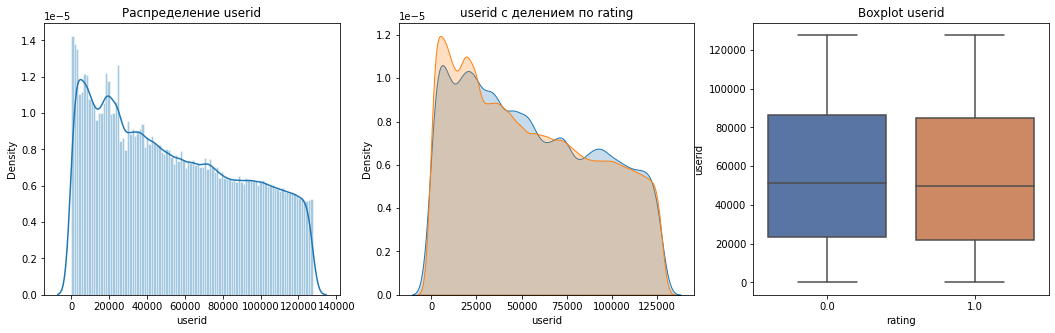

In [19]:
get_gr_num('userid', 100)

- Первые пользователи были более лояльны в оценках.



**Товары**

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


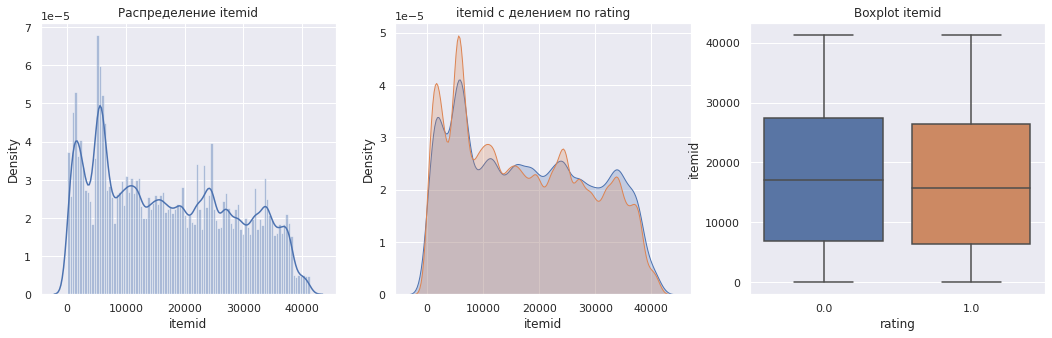

In [20]:
get_gr_num('itemid', 100)

- Первые товары оцениваются в среднем лучше.

**Дубликаты**

In [21]:
train[['userid', 'itemid', 'rating']].duplicated().sum()

43746

- Довольно много дублей, посмотрим, что можно сделать с этой особенностью датасета.

**Целевая переменная**

In [22]:
train.rating.value_counts()

1.0    728290
0.0    129605
Name: rating, dtype: int64

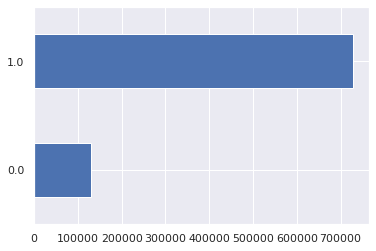

In [23]:
train['rating'].value_counts(ascending=True).plot(kind='barh')

- Два значения 1 и 0.
- Преобладают значения 1.

### Удалим дубли и обучим базовую модель на очищенном дата сете
Для этого создадим временный дата фрем

In [24]:
df_tmp = train[['userid', 'itemid', 'rating']]

Удалим дубли

In [25]:
df_tmp = df_tmp.drop_duplicates().reset_index(drop=True)

Заново разобьем данные на трейн и тест

In [26]:
train_data, test_data = train_test_split(df_tmp, random_state=32, shuffle=True)

Подготовим соо матрицу

In [27]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

Обучим модель

In [28]:
model = model.fit(ratings_coo, epochs=NUM_EPOCHS,
                  num_threads=NUM_THREADS)

Получим предсказания

In [29]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

Оценим качество

In [30]:
sklearn.metrics.roc_auc_score(test_data.rating, preds)

0.7156372656452259

**Предварительный вывод:** скор ухудшился при удалении дублей за счет сокращения количества наблюдений.

**Дополнительный комментарий:** *Кроме удаления дублей, попробовал увеличить количество дублей (раз удаление дублей ухудшает скор, было предположение, что если сбалансировать целевую переменную за счет добавления дублирующих строк, скор улучшится). Однако в данном случае модель переобучается. Скор на трейне улучшается, а на тесте ухудшается. Вывод: оставил исходный датасет для дальнейшей работы.*

## Гиперпараметры Lightfm
- Настроим гиперпараметры модели.
- Посмотрим на графиках как меняется скор в зависимости от различных гиперпараметров. Для этого собранные данные запишем в дата фрейм.
- Воспользоваться **RandomizedSearchCV** не получилось, поэтому перебор параметров сделал вложенными циклами с периодическим сохранением собранных параметров в файл .csv
- Поменял формат подготовки данных: теперь мы сначала создаем соо-матрицу, а затем разбиваем её на train и test с помощью **random_train_test_split**.

In [31]:
# COO Матрицы
# Основная
ratings_coo = sparse.coo_matrix((train.rating, (train.userid, train.itemid)))

# Разбиваем наш датасет на обучающую и тестовую выборки
train_m, test_m = random_train_test_split(ratings_coo, test_percentage=0.2)

### Подберем гиперпараметры

In [32]:
best_score = 0
best_param = {}
df_param = pd.DataFrame(columns=[
                        'LERNING_SCHEDULE', 'NUM_COMPONENTS', 'NUM_EPOCHS', 'LERNING_RATE', 'score'])

In [33]:
# число потоков процессора
NUM_THREADS = 12


LERNING_SCHEDULE = ['adagrad', 'adadelta']

# число параметров вектора
NUM_COMPONENTS = [30, 60, 100, 120, 160, 200, 260, 300]

# число эпох обучения
NUM_EPOCHS = [20, 25, 30, 50, 70]

# Шаг обучения
LERNING_RATE = [0.03, 0.05, 0.07, 0.09]

Код для перебора гиперпараметров, промежуточного тестирования модели и записи результатов в дата фрейм.

In [ ]:
for lern_sch in LERNING_SCHEDULE:
    for num_comp in NUM_COMPONENTS:
        for num_ep in NUM_EPOCHS:
            for lern_rate in LERNING_RATE:
                # Создаем модель
                model = LightFM(learning_rate=lern_rate, loss='logistic', learning_schedule=lern_sch,
                                no_components=num_comp, random_state=32)

                # Обучаем модель
                model = model.fit(train_m, epochs=num_ep,
                                  num_threads=NUM_THREADS)

                preds = model.predict(test_m.row, test_m.col)
                score_tmp = sklearn.metrics.roc_auc_score(test_m.data, preds)
                param_tmp = {
                    'LERNING_SCHEDULE': lern_sch,
                    'NUM_COMPONENTS': num_comp,
                    'NUM_EPOCHS': num_ep,
                    'LERNING_RATE': lern_rate,
                    'score': score_tmp
                }
                if score_tmp > best_score:
                    best_score = score_tmp
                    best_param = param_tmp

                df_param = df_param.append(param_tmp, ignore_index=True)
                print('---------------')
                print(df_param.tail())
                print('---------------')
                print('Score: ', score_tmp)
                print('BEST Score: ', best_score)
                print()

            df_param.to_csv('lightfm_param.csv', index=False)

- Код запускался параллельно работе над проектом на платформе **Google Colab**, поэтому в отчетном ноутбуке запускать его не будем, а просто загрузим собранные данные.

In [34]:
df_param = pd.read_csv('lightfm_param.csv')
df_param

,Unnamed: 0,LERNING_SCHEDULE,NUM_COMPONENTS,NUM_EPOCHS,LERNING_RATE,score
0,0,adagrad,30,20,0.03,0.714426
1,1,adagrad,30,20,0.05,0.743822
2,2,adagrad,30,20,0.07,0.752324
3,3,adagrad,30,20,0.09,0.751943
4,4,adagrad,30,25,0.03,0.726050
...,...,...,...,...,...,...
155,155,adagrad,300,50,0.09,0.748784
156,156,adagrad,300,70,0.03,0.750396
157,157,adagrad,300,70,0.05,0.746846
158,158,adagrad,300,70,0.07,0.745639


- Собрано 160 вариантов настроек модели.
- Построим графики зависимости Score от Lerning rate для различного количества эпох обучения и для различных длин векторов. 

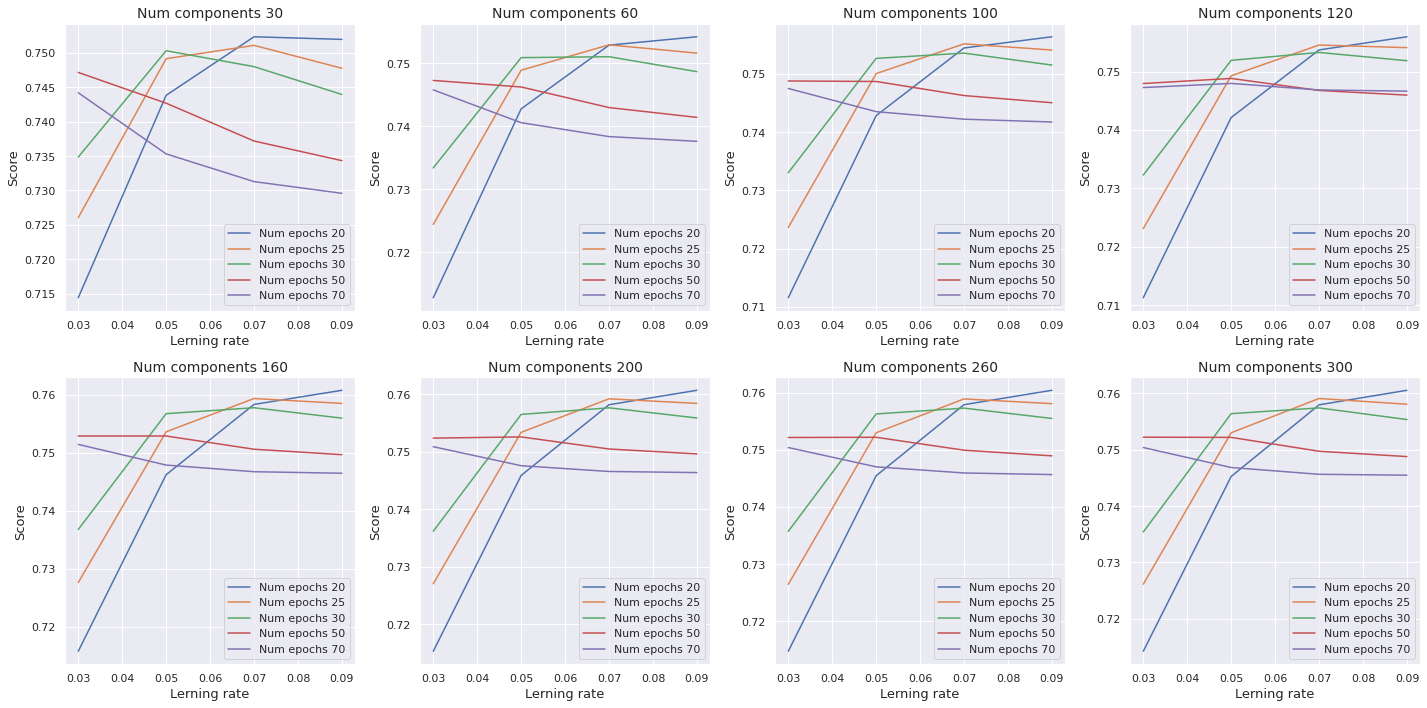

In [35]:
# Количество столбцов и строк для систем координат
col = 4
row = 2

# Список координат для графиков
x = [i for i in range(0, col)]*row
y = [i for i in range(0, row) for c in range(0, col)]

# Начальные данные для графиков
fig = plt.figure(figsize=(20, 10))
gs = fig.add_gridspec(row, col)
componetns_list = df_param['NUM_COMPONENTS'].unique()
epoc_list = df_param['NUM_EPOCHS'].unique()

for i, num_comp in enumerate(componetns_list):
    df_param_tmp_comp = df_param[df_param['NUM_COMPONENTS'] == num_comp]
    with sns.axes_style("darkgrid"):
        ax = fig.add_subplot(gs[y[i], x[i]])
        ax.set_title('Num components {}'.format(num_comp), fontsize=14)
        plt.xlabel('Lerning rate', fontsize=13)
        plt.ylabel('Score', fontsize=13)
        for num_epoc in epoc_list:
            plt.plot(df_param_tmp_comp[df_param_tmp_comp.NUM_EPOCHS == num_epoc]['LERNING_RATE'],
                     df_param_tmp_comp[df_param_tmp_comp.NUM_EPOCHS == num_epoc]['score'], label='Num epochs {}'.format(num_epoc))
        plt.legend(loc=4)

fig.tight_layout()

**Предварительные выводы:**
- Score зависит от Lerning rate: при малых значения Score функция интенсивно возрастает до определенного максимума, затем плавно снижается.
- Максимум функции смещается в сторону уменьшения показателей Score (влево) при увеличении количества эпох обучения.
- С ростом числа эпох обучения функция сглаживается по горизонтали и не достигает максимальных значений, которые достигаются при более низких значениях количества эпох обучения.
- С увеличением количества компонентов вектора, функция позже затухает, поэтому в рассматриваемом диапазоне Lerning rate не очевидно, что мы видим максимум функции на малых значениях количества эпох обучения.

Посмотрим на гиперпараметры для максимального значения score.

In [36]:
df_param[df_param.score == df_param.score.max()]

,Unnamed: 0,LERNING_SCHEDULE,NUM_COMPONENTS,NUM_EPOCHS,LERNING_RATE,score
83,83,adagrad,160,20,0.09,0.760773


- С помощью подбора гиперпараметров удалось улучшить базовый score.
- Предсказания модели с данными гиперпараметрами показали score 0.77139 на платформе Kaggle (7 место на лидерборде в момент публикации результата).

Протестируем параметры модели с бОльшими значениями Lerning rate и с несколькими более низкими показателями количества эпох обучения.
- Загрузим собранные данные аналогичным образом и посмотрим на графики.

In [37]:
df_param2 = pd.read_csv('lightfm_param2.csv')

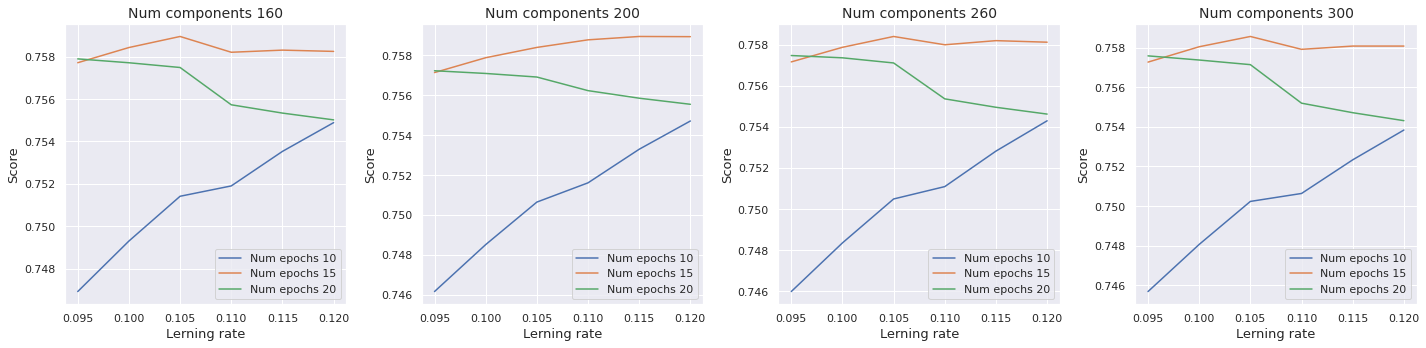

In [38]:
# Количество столбцов и строк для систем координат
col = 4
row = 1

# Список координат для графиков
x = [i for i in range(0, col)]*row
y = [i for i in range(0, row) for c in range(0, col)]

# Начальные данные для графиков
fig = plt.figure(figsize=(20, 5))
gs = fig.add_gridspec(row, col)
componetns_list = df_param2['NUM_COMPONENTS'].unique()
epoc_list = df_param2['NUM_EPOCHS'].unique()

for i, num_comp in enumerate(componetns_list):
    df_param_tmp_comp = df_param2[df_param2['NUM_COMPONENTS'] == num_comp]
    with sns.axes_style("darkgrid"):
        ax = fig.add_subplot(gs[y[i], x[i]])
        ax.set_title('Num components {}'.format(num_comp), fontsize=14)
        plt.xlabel('Lerning rate', fontsize=13)
        plt.ylabel('Score', fontsize=13)
        for num_epoc in epoc_list:
            plt.plot(df_param_tmp_comp[df_param_tmp_comp.NUM_EPOCHS == num_epoc]['LERNING_RATE'],
                     df_param_tmp_comp[df_param_tmp_comp.NUM_EPOCHS == num_epoc]['score'], label='Num epochs {}'.format(num_epoc))
        plt.legend(loc=4)

fig.tight_layout()

In [39]:
df_param2[df_param2.score == df_param2.score.max()]

,LERNING_SCHEDULE,NUM_COMPONENTS,NUM_EPOCHS,LERNING_RATE,score
5,adagrad,160,15,0.105,0.758961


**Выводы:**
- Видно, что график для количества эпох обучения равным 20, в следующем диапазоне Lerning rate, затухает.
- В данном диапазоне Lerning rate максимальных значений достигают графики с количеством эпох обучения 15, однако максимальные значения score не перекрывают максимум предыдущего рассматриваемого диапазона.
- Для дальнейшей работы оставим наилучшие параметры, определенные в первом эксперименте. 

In [40]:
df_param[df_param.score == df_param.score.max()]

,Unnamed: 0,LERNING_SCHEDULE,NUM_COMPONENTS,NUM_EPOCHS,LERNING_RATE,score
83,83,adagrad,160,20,0.09,0.760773


## SVD
- Попробуем сделать предсказания с помощью другой модели - SVD
- Сравним полученные результаты с уже достигнутым прогрессом.
- Для корректности сравнения моделей, будем получать предсказания не на части трейна, а на тестовом датасете и сравнивать результаты на платформе Kaggle.

Подготовим данные

In [41]:
reader = Reader(rating_scale=(0, 1))

df_train = train[['userid', 'itemid', 'rating']]
data = Dataset.load_from_df(df_train, reader)

trainingSet = data.build_full_trainset()

Обучим модель

In [42]:
svd = SVD()
svd.fit(trainingSet)

Получим предсказания на тесте kaggle

In [43]:
df_test = test[['userid', 'itemid']]
df_test['rating'] = 0
data_test = Dataset.load_from_df(
    df_test[['userid', 'itemid', 'rating']], reader)

testSet = data_test.construct_testset(data_test.raw_ratings)
predictions = svd.test(testSet)
pred = [pred.est for pred in predictions]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [44]:
len(pred)

285965

**Результат:**
- Score на Kaggle получился 0.74679. Это лучше baseline, но хуже модели Lightfm.

## Гиперпараметры SVD
- Попробуем подобрать настройки для SVD-модели.

In [ ]:
model = SVD(random_state=32, verbose=True)

param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.005, 0.01],
              'n_factors': [60, 100, 160, 200]}
gs = GridSearchCV(SVD, param_grid, measures=[
                  'rmse', 'mae'], cv=10, joblib_verbose=1)

gs.fit(data)

# best RMSE score
print(gs.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

- В итоговом ноутбуке код запускать не будем из-за продолжительной работы.
- Лучшие параметры получились: n_epochs=30, lr_all=0.01, n_factors=60
- Сделаем предсказания с лучшими параметрами SVD-модели.

In [45]:
svd = SVD(random_state=32, n_epochs=30, lr_all=0.01, n_factors=60)
svd.fit(trainingSet)

predictions = svd.test(testSet)
pred = [pred.est for pred in predictions]
len(pred)

285965

**Выводы:**
- Подобрали оптимальные параметры.
- Еще раз получили предсказания SVD-модели.
- Результат на Kaggle улучшился до 0.76104, что очень неплохо, но всё равно не дотягивает до результатов модели Lightfm
- Для дальнейшего тестирования остановимся на Lightfm модели.

## Проблема холодного старта
- В документации к библиотеке lightfm предлагается решать проблему холодного старта передачей в модель дополнительных матриц с параметрами товаров и пользователей, чтобы модель на основе данных параметров могла предложить рекомендации новым пользователям, а также рекомендовать пользователям новые товары.
- Обратная сторона данных действий - возможное ухудшение общего качества рекомендательной системы (ухудшение значений итоговой метрики).
- Обработаем признаки из предлагаемых датасетов и попробуем добавить их к моделе.
- На первом этапе не будем рассматривать признаки, которые есть в train, но отсутствуют в test.
- Если добавление признаков будет давать положительный эффект, посмотрим, что можно получить из оставшихся данных.

### EDA
**Пересекающиеся признаки в train и test**
- verified
- reviewTime
- asin
- reviewerName
- unixReviewTime
- vote
- style
- image
- rating

In [46]:
# Создадим временный дата фрем для обработки признаков
df_eda = train[['verified', 'reviewTime', 'asin', 'reviewerName',
                'unixReviewTime', 'vote', 'style', 'image', 'userid', 'itemid', 'rating']]

In [47]:
df_eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   verified        857895 non-null  bool   
 1   reviewTime      857895 non-null  object 
 2   asin            857895 non-null  object 
 3   reviewerName    857719 non-null  object 
 4   unixReviewTime  857895 non-null  int64  
 5   vote            118740 non-null  object 
 6   style           444406 non-null  object 
 7   image           7142 non-null    object 
 8   userid          857895 non-null  int64  
 9   itemid          857895 non-null  int64  
 10  rating          857895 non-null  float64
dtypes: bool(1), float64(1), int64(3), object(6)
memory usage: 66.3+ MB


**verified** - был ли отзыв верифицирован
- Пропусков нет.

True     745243
False    112652
Name: verified, dtype: int64



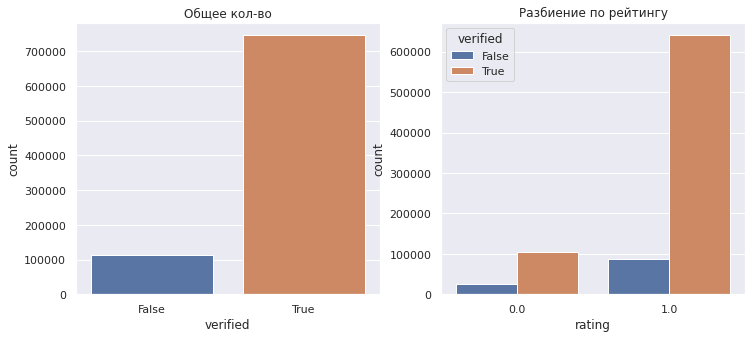

In [48]:
get_gr_counts('verified')

Заменим данные на 1 и 0

In [49]:
df_eda.verified = df_eda.verified.astype('int32')

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5168: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


Посмотрим на среднее значение целевой переменной для групп

In [50]:
print(df_eda[df_eda.verified == 1].rating.mean())
print(df_eda[df_eda.verified == 0].rating.mean())

0.8590540266731791
0.7819301920960124


**Предварительный вывод:** Средний балл у авторизованных отзывов выше. Признак должен влиять но скор.

**reviewTime - когда был написан отзыв**
- reviewTime - данный признак дублирует аналогичную информацию из колонки unixReviewTime.
- Пропусков нет ни там, ни там.
- Удалим reviewTime, как менее удобный формат для дальнейшей работы.

In [51]:
df_eda = df_eda.drop(['reviewTime'], axis=1)

**asin**

In [52]:
df_eda.asin.value_counts()

B00BUKL666    5491
B00D3M2QP4    4733
B008QMX2SG    4654
B00R7PWK7W    2547
B000X3TPHS    2300
              ... 
B001682U6M       1
B00AU8UTYO       1
B008J46E9A       1
B0015D21XU       1
B00KS712Q6       1
Name: asin, Length: 41302, dtype: int64

- Похоже на артикул товара.
- Проверим пять самых популярных артикулов на соответствие с itemid

In [53]:
print(train[train.asin == 'B00BUKL666']['itemid'].value_counts())
print(train[train.asin == 'B00D3M2QP4']['itemid'].value_counts())
print(train[train.asin == 'B008QMX2SG']['itemid'].value_counts())
print(train[train.asin == 'B00R7PWK7W']['itemid'].value_counts())
print(train[train.asin == 'B000X3TPHS']['itemid'].value_counts())

22208    5491
Name: itemid, dtype: int64
23540    4733
Name: itemid, dtype: int64
24556    4654
Name: itemid, dtype: int64
32046    2547
Name: itemid, dtype: int64
5195    2300
Name: itemid, dtype: int64


**Вывод:** Полное соответствие itemid. Признак можно удалять.

In [54]:
df_eda = df_eda.drop(['asin'], axis=1)

**reviewerName** - текстовый аналог userid. Признак можно удалять по аналогии с артикулом.

In [55]:
df_eda = df_eda.drop(['reviewerName'], axis=1)

**unixReviewTime** - время публикации отзыва
- Пропусков нет.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


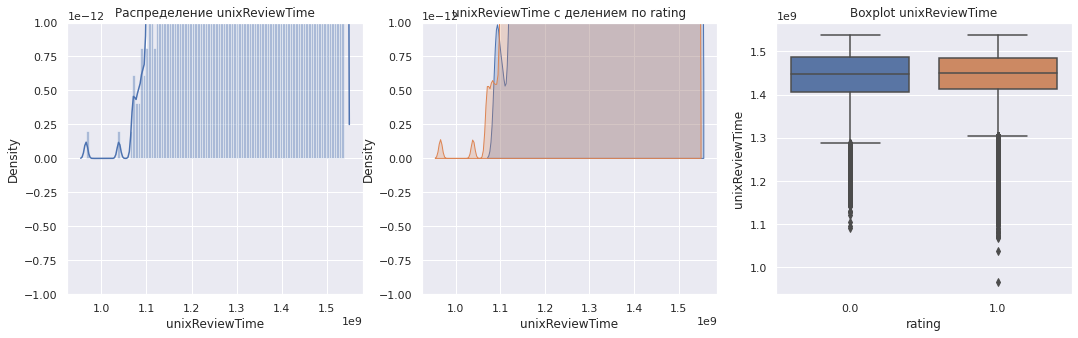

In [56]:
get_gr_num('unixReviewTime', 100)

**Предварительный вывод:**
- Видны периоды равномерной оценки товаров, периоды преобладания положительных отзывов и периоды преобладания отрицательных отзывов.
- Также видны пики и провалы количества отзывов.
- Попробуем учесть это матрице дополнительных признаков для модели.

In [57]:
df_eda['review_time_old'] = (
    df_eda['unixReviewTime'] < 1350000000).astype('int32')
df_eda['review_time_new'] = (
    df_eda['unixReviewTime'] > 1490000000).astype('int32')
df_eda['review_time_middle'] = (
    df_eda['review_time_old'] + df_eda['review_time_new'] == 0).astype('int32')

Посмотрим есть ли различия в созданных группах

In [58]:
print(df_eda[df_eda.review_time_old == 1].rating.mean())
print(df_eda[df_eda.review_time_new == 1].rating.mean())
print(df_eda[df_eda.review_time_middle == 1].rating.mean())

0.8067964731814842
0.8357517064475457
0.8565430133651467


- Показатели групп растут по 2%.
- Удалим старый признак unixReviewTime

In [59]:
df_eda = df_eda.drop(['unixReviewTime'], axis=1)

**vote** - количество голосований за отзыв

In [60]:
df_eda.vote.unique()

array([nan, '28', '2', '3', '4', '5', '45', '9', '55', '8', '39', '13',
       '20', '7', '6', '16', '18', '27', '54', '24', '10', '11', '46',
       '29', '15', '12', '14', '136', '22', '33', '131', '21', '17', '19',
       '23', '30', '26', '31', '25', '113', '334', '52', '37', '43', '56',
       '44', '57', '123', '91', '41', '146', '42', '70', '34', '49', '77',
       '35', '115', '53', '68', '560', '32', '265', '38', '135', '58',
       '50', '92', '189', '250', '155', '47', '78', '118', '62', '36',
       '105', '926', '106', '40', '107', '86', '375', '139', '1,626',
       '79', '71', '66', '109', '82', '85', '89', '94', '111', '342',
       '83', '516', '96', '278', '98', '65', '195', '88', '80', '48',
       '84', '141', '112', '72', '59', '163', '87', '81', '157', '64',
       '257', '63', 20.0, 2.0, 3.0, 5.0, 10.0, 4.0, 64.0, 12.0, 14.0,
       52.0, 6.0, 16.0, 13.0, 8.0, 18.0, 19.0, 9.0, 43.0, 37.0, 24.0, 7.0,
       17.0, 47.0, 44.0, 40.0, 35.0, 15.0, 11.0, 33.0, 26.0, 23.

- Есть пропуски. Будем считать, что в данном случае голосований за отзыв не было. Заменим пропуски на 0.
- Данные представлены в текстовом формате. Преобразуем в числовой.

In [61]:
df_eda.vote = df_eda.vote.fillna(0)
df_eda.vote = df_eda.vote.astype('str')
df_eda.vote = df_eda.vote.apply(lambda x: x.replace(',', ''))
df_eda.vote = df_eda.vote.astype('float')
df_eda.vote = df_eda.vote.astype('int')

Разобьем на группы:
- 0
- до 100
- до 1000
- свыше 1000

In [62]:
df_eda['vote_0'] = (df_eda.vote == 0).astype('int32')
df_eda['vote_0_100'] = ((df_eda.vote != 0) & (
    df_eda.vote < 100)).astype('int32')
df_eda['vote_100_1000'] = ((df_eda.vote >= 100) & (
    df_eda.vote < 1000)).astype('int32')
df_eda['vote_1000'] = (df_eda.vote >= 1000).astype('int32')

Посмотрим разницу в средних оценках созданных групп.

In [63]:
print(df_eda[df_eda.vote_0 == 1].rating.mean())
print(df_eda[df_eda.vote_0_100 == 1].rating.mean())
print(df_eda[df_eda.vote_100_1000 == 1].rating.mean())
print(df_eda[df_eda.vote_1000 == 1].rating.mean())

0.8621669338636686
0.7664441115990962
0.7846975088967971
0.2


**Предварительный вывод:**
- Наблюдается существенное различие в средних оценках созданных групп.
- Признак должен положительно влиять на итоговый скор.
- Удалим столбец vote.

In [64]:
df_eda = df_eda.drop(['vote'], axis=1)

**style** - метаданные (характеристики товаров).

In [65]:
df_eda['style'].isnull().sum()

413489

**Предварительный вывод:**
- Очень много пустых значений.
- Пока сделаем бинарный признак для товаров, где были характеристики и где их не было.
- Удалим старый признак style.

In [66]:
df_eda['style_yes'] = (df_eda['style'].isnull() == False).astype('int32')
df_eda = df_eda.drop(['style'], axis=1)

**image** - изображение товара

In [67]:
df_eda['image'].isnull().sum()/len(df_eda)

0.991674971878843

**Вывод:** У 99% товаров отсутствует изображение. Признак бесполезен, можно удалять.

In [68]:
df_eda = df_eda.drop(['image'], axis=1)

**Итоговая матрица признаков**

In [69]:
df_eda

,verified,userid,itemid,rating,review_time_old,review_time_new,review_time_middle,vote_0,vote_0_100,vote_100_1000,vote_1000,style_yes
0,1,102179,37138,1.0,0,0,1,1,0,0,0,0
1,1,3625,17322,1.0,0,0,1,1,0,0,0,1
2,1,39495,5600,1.0,0,0,1,0,1,0,0,0
3,1,72854,30249,1.0,0,0,1,1,0,0,0,0
4,1,74859,4349,1.0,0,0,1,1,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
857890,1,59433,2566,1.0,0,0,1,1,0,0,0,1
857891,1,86473,5828,0.0,0,0,1,1,0,0,0,1
857892,0,88,3251,1.0,0,0,1,1,0,0,0,1
857893,1,41540,22208,1.0,0,0,1,1,0,0,0,0


Корреляции признаков

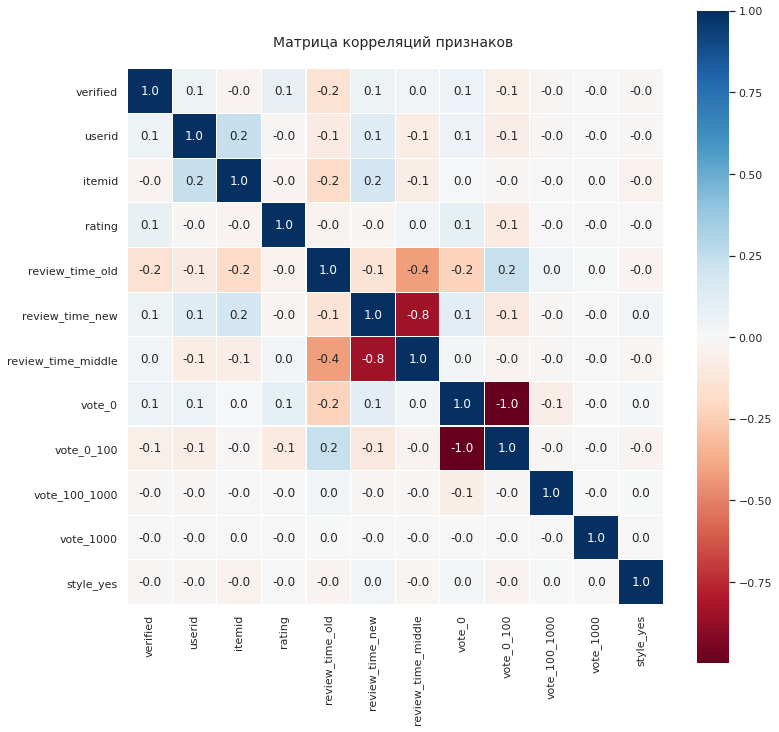

In [70]:
sns.set(font_scale=1)
plt.subplots(figsize=(12, 12))
plt.title('Матрица корреляций признаков \n', fontsize=14)
sns.heatmap(df_eda.corr(), square=True,
            annot=True, fmt=".1f", linewidths=0.1, cmap="RdBu")

- Наблюдается 100% обратная корреляция между признаками vote_0 и vote_0_100, что в общем-то логично. Один из признаков не будем использовать для передачи в модель.
- Наблюдается высокая корреляция между новыми отзывами и отзывами написанными в средний интервал времени, однако данные признаки оставим для тестирования модели, т. к. графики и расчеты, сделанные выше, показывают их различное влияние на итоговую метрику.

### Протестируем модель с дополнительной матрицей признаков товаров
Алгоритм добавления признаков взят из видеовстречи по проекту.

In [71]:
list_item_features = ['verified', 'review_time_old', 'review_time_new',
                      'review_time_middle', 'vote_0_100', 'vote_100_1000', 'vote_1000', 'style_yes']

Сформируем id для продуктов и пользователей

In [72]:
df_eda = generate_int_id(df_eda, 'userid_num')
df_eda = generate_int_id(df_eda, 'itemid_num')

Создадим столбец с обобщенными данными по признакам товаров

In [73]:
df_eda['item_features'] = create_features(
    df_eda, list_item_features, 'itemid_num')

Создадим признаки для передачи в модель

In [74]:
item_feature_list = generate_feature_list(df_eda, list_item_features)

In [75]:
dataset = DS()
dataset.fit(
    set(df_eda['userid_num']),
    set(df_eda['itemid_num']),
    user_features=None,
    item_features=item_feature_list)

In [76]:
item_features = dataset.build_item_features(df_eda['item_features'])

Протестируем модель с добавлением признаков товаров

In [77]:
# число потоков процессора
NUM_THREADS = 12 

# число параметров вектора 
NUM_COMPONENTS = 160 

# число эпох обучения
NUM_EPOCHS = 20

In [78]:
# Создаем модель
model = LightFM(learning_rate=0.09, loss='logistic', learning_schedule='adagrad',
                no_components=NUM_COMPONENTS, random_state=32)

In [79]:
#Обучаем модель
model = model.fit(train_m, epochs=NUM_EPOCHS,
                  num_threads=NUM_THREADS, item_features=item_features)

In [80]:
preds = model.predict(test_m.row, test_m.col, item_features=item_features)

In [81]:
sklearn.metrics.roc_auc_score(test_m.data, preds)

0.7002068088350014

**Выводы:**
- Значением метрики ухудшилось.
- Добавление признаков дает возможность делать рекомендации новым покупателям, а также рекомендовать покупателям новые товары, однако это ухудшает общее качество метрики.
- В связи с этим брать в работу дополнительные признаки из файла .json, а также преобразовывать признаки из test не будем.
- Варианты выбора моделей, улучшения их качества, а также обработки и добавления дополнительных признаков отработаны.

## Дополнительные гипотезы
- Внимание: данные методы могут быть неприменимы к реальным условиям, однако мы работаем с предложенными данными и ничего не мешает нам выявить некоторые закономерности в имеющихся датасетах.
- Посмотрим, как можно обогатить предложенный датасет test для Kaggle

**Посмотрим на пользователей в train и test**

In [82]:
user_train = set(train.userid)
user_test = set(test.userid)

In [83]:
print('Пользователей в трейн:', len(user_train))
print('Пользователей в тест:', len(user_test))
print('Пользователей, которые есть в трейн, но нет в тест:',
      len(user_test-user_train))

Пользователей в трейн: 127448
Пользователей в тест: 109357
Пользователей, которые есть в трейн, но нет в тест: 48


**Вывод:** У нас всего 48 пользователей, которые есть в train, но нет в test, а это значит, что в данном случае мы можем "перетащить" некоторые свойства присущие пользователям в тестовую выборку.

**Идея для тестирования:**
- Создадим свойство покупателя, которое будет показывать как данный покупатель в среднем оценивает товар.
- Перенесем данное свойство в тестовый набор данных.
- Для 48-ми пользователей, которых нет в train, среднюю оценку сделаем нулевой.
- Сформируем на основе нового свойства дополнительный параметр для обучения модели и протестируем результат на платформе kaggle.

In [84]:
# Создадим среднюю оценку для каждого пользователя
# Перенесем параметр в тестовый дата сет
overoll_mean = train.groupby(['userid'])['overall'].mean()
train['overall_mean'] = train.userid.apply(lambda x: overoll_mean[x])
test['overall_mean'] = test.userid.apply(
    lambda x: overoll_mean[x] if x in user_train else 0)

Будем считать, что если средняя оценка пользователя по всем товарам более 3.5, то товары в магазине ему в основном нравятся. В противном случае, товары пользователю в основном не нравятся.

In [85]:
train['overall_mean'] = (train['overall_mean'] >= 3.5).astype('int32')
test['overall_mean'] = (test['overall_mean'] >= 3.5).astype('int32')

Подготовим признак user_features для модели

In [86]:
list_user_features = ['overall_mean']

In [87]:
# Формируем списки Id для пользователей и продуктов
train = generate_int_id(train, 'userid_num')
test = generate_int_id(test, 'userid_num')
train = generate_int_id(train, 'itemid_num')
test = generate_int_id(test, 'itemid_num')

In [88]:
# создание признаков для передачи в алгоритм
train['user_features'] = create_features(
    train, list_user_features, 'userid_num')
test['user_features'] = create_features(
    test, list_user_features, 'userid_num')

In [89]:
# генерация списка признаков
user_feature_list = generate_feature_list(train, list_user_features)

In [90]:
dataset = DS()
dataset.fit(
    set(train['userid_num']),
    set(train['itemid_num']),
    user_features=user_feature_list,
    item_features=None)

In [91]:
user_features = dataset.build_user_features(train['user_features'])

In [92]:
# генерация списка признаков test
user_feature_list_test = generate_feature_list(test, list_user_features)

In [93]:
dataset.fit(
    set(test['userid_num']),
    set(test['userid_num']),
    user_features=user_feature_list,
    item_features=None)

In [94]:
user_features_test = dataset.build_user_features(test['user_features'])

**Обучим модель с дополнительными признаками user_features**

In [95]:
# Обучаем на всём трейн
model = model.fit(ratings_coo, epochs=NUM_EPOCHS,
                  num_threads=NUM_THREADS, user_features=user_features)

Протестируем на Kaggle

In [96]:
preds = model.predict(test.userid.values,
                      test.itemid.values, user_features=user_features_test)

In [97]:
preds.min(), preds.max()

(-18.518383026123047, 23.903488159179688)

Нормализуем

In [98]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()
normalized_preds.min(), normalized_preds.max()

(0.0, 1.0)

Submission

In [99]:
submission['rating'] = normalized_preds
submission

,Id,rating
0,0,0.451175
1,1,0.438368
2,2,0.424507
3,3,0.420692
4,4,0.447547
...,...,...
285960,285960,0.451608
285961,285961,0.410453
285962,285962,0.436233
285963,285963,0.446037


**Вывод по разделу:**
- Тестирование данной гипотезы дало результат 0.75122 - неплохой результат, но не лучший из имеющихся.
- Второе предположение: усреднить предсказания моделей без дополнительных признаков и с дополнительными признаками.
- В результате тестирования второй гипотезы получен лучший результат: 0.77793 и 3-е место на лидерборде Kaggle на день тестирования.

В результате улучшения качества метрики, протестирован аналогичный подход применительно к товарам.

In [100]:
item_train = set(train.itemid)
item_test = set(test.itemid)

In [101]:
print('Товары в трейн:', len(item_train))
print('Товары в тест:', len(item_test))
print('Товары, которые есть в трейн, но нет в тест:', len(item_test-item_train))

Товары в трейн: 41302
Товары в тест: 37876
Товары, которые есть в трейн, но нет в тест: 18


**Предварительный вывод:** Получили всего 18 товаров в тесте, которых нет в train, значит метод добавления признака средней оценки, используемый для покупателей, применим и для товаров.

Сформируем признак для товаров

In [102]:
overoll_mean_item = train.groupby(['itemid'])['overall'].mean()

train['overoll_mean_item'] = train.itemid.apply(lambda x: overoll_mean_item[x])
test['overoll_mean_item'] = test.itemid.apply(
    lambda x: overoll_mean_item[x] if x in item_train else 0)

train['overoll_mean_item'] = (
    train['overoll_mean_item'] >= 3.5).astype('int32')
test['overoll_mean_item'] = (test['overoll_mean_item'] >= 3.5).astype('int32')

list_item_features = ['overoll_mean_item']

- Дальнейшие действия со средней оценкой товаров строго аналогичны действиям по добавлению пользовательской средней оценки.
- В связи с длительностью вычислений в итоговом ноутбуке приведем только итоги данной работы.
- В результате добавления признаков товаров, удалось поднять итоговую метрику до максимального значения: 0.78036 и сохранить 3-е место на лидерборде Kaggle на день размещения результата.

## Итоги проекта
- Познакомились с библиотекой Lightfm для построения рекомендательной системы.
- Настроили базовую модель, получили базовую метрику ROC AUC предсказаний модели на уровне 0.745.
- Протестировали входные данные, попробовали убрать дубли, но результат ухудшился на 4% по сравнению с базовой моделью.
- Попробовали сбалансировать тренировочный датасет по целевой переменной. Это привело к переобучению модели: на тренировочных данных, разбитых на train и test, результат предсказаний улучшился до 90%, однако результат на тестовых данных для Kaggle ухудшился до 55%.
- Подобрали гиперпараметры базовой модели. Посмотрели графически влияние переменных: Learning rate, количество эпох обучения и число компонентов вектора на качество предсказания модели.
- С оптимальными параметрами score на платформе Kaggle составил 0.77139, что соответствовало 7-му месту на лидерборде на момент публикации результатов. Таким образом, настройка модели даже без дополнительных признаков дала очень хороший прирост качества.
- Протестировали альтернативный подход – SVD-модель. Получен результат 0.74679.
- Подобрали гиперпараметры SVD-модели. Результат улучшился до 0.76104. Результат хороший, но хуже, чем у Lightfm-модели, поэтому в дальнейшем продолжили тестирование на ней.
- Для решения проблемы холодного старта решили добавить в модель дополнительные признаки товаров.
- Провели анализ признаков на пропуски, влияние их на целевую переменную и корреляцию между собой. Отобранные в результате анализа признаки преобразовали в формат для передачи в модель.
- Качество предсказаний модели ожидаемо ухудшилось до 0.700.
- Провели эксперимент по добавлению среднего уровня оценки товаров пользователями в модель, как признак покупателя. Результат метрики неплохой, но не лучший 0.75122.
- Усреднили предсказания модели без дополнительных признаков и с добавлением признаков пользователей. Результат метрики улучшился до максимума за всё предыдущее время 0.77793, что соответствует 3-му месту на лидерборде Kaggle на день публикации.
- Вдохновившись успехом, добавили в модель среднюю оценку товаров, как дополнительный признак для товаров. Аналогичным образом усреднили предсказания модели без дополнительных признаков и с модели с добавлением признаков товаров и пользователей. Получили максимальный окончательный результат метрики 0.78036, что также соответствует 3-му место лидерборда Kaggle.


**Общий вывод:** Сформирована эффективная рекомендательная система для интернет-магазина. Научились работать со специализированными библиотеками и настраивать их параметры. Правильная настройка гиперпараметров модели дает существенный прирост качества предсказаний. Проанализированы и подготовлены данные для модели из предлагаемых дата сетов. Протестированы альтернативные гипотезы, которые улучшают качество модели в существующих условиях. Получен качественный результат предсказаний модели.

